In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import os
import xml.etree.ElementTree as ET
import datetime as dt
import sys


#1)Converting XML to CSV

*   I used a pre designed script made by Jason Meno for converting
*   Here is Github repository of that script:
https://github.com/jameno/Simple-Apple-Health-XML-to-CSV





In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simple Apple Health XML to CSV
==============================
:File: convert.py
:Description: Convert Apple Health "export.xml" file into a csv
:Version: 0.0.2
:Created: 2019-10-04
:Updated: 2023-10-29
:Authors: Jason Meno (jam)
:Dependencies: An export.xml file from Apple Health
:License: BSD-2-Clause
"""


# %% Function Definitions

def preprocess_to_temp_file(file_path):
    """
    The export.xml file is where all your data is, but Apple Health Export has
    two main problems that make it difficult to parse:
        1. The DTD markup syntax is exported incorrectly by Apple Health for some data types.
        2. The invisible character \x0b (sometimes rendered as U+000b) likes to destroy trees. Think of the trees!

    Knowing this, we can save the trees and pre-processes the XML data to avoid destruction and ParseErrors.
    """

    print("Pre-processing and writing to temporary file...", end="")
    sys.stdout.flush()

    temp_file_path = "temp_preprocessed_export.xml"
    with open(file_path, 'r') as infile, open(temp_file_path, 'w') as outfile:
        skip_dtd = False
        for line in infile:
            if '<!DOCTYPE' in line:
                skip_dtd = True
            if not skip_dtd:
                line = strip_invisible_character(line)
                outfile.write(line)
            if ']>' in line:
                skip_dtd = False

    print("done!")
    return temp_file_path

def strip_invisible_character(line):
    return line.replace("\x0b", "")


def xml_to_csv(file_path):
    """Loops through the element tree, retrieving all objects, and then
    combining them together into a dataframe
    """

    print("Converting XML File to CSV...", end="")
    sys.stdout.flush()

    attribute_list = []

    for event, elem in ET.iterparse(file_path, events=('end',)):
        if event == 'end':
            child_attrib = elem.attrib
            for metadata_entry in list(elem):
                metadata_values = list(metadata_entry.attrib.values())
                if len(metadata_values) == 2:
                    metadata_dict = {metadata_values[0]: metadata_values[1]}
                    child_attrib.update(metadata_dict)
            attribute_list.append(child_attrib)

            # Clear the element from memory to avoid excessive memory consumption
            elem.clear()

    health_df = pd.DataFrame(attribute_list)

    # Every health data type and some columns have a long identifer
    # Removing these for readability
    health_df.type = health_df.type.str.replace('HKQuantityTypeIdentifier', "")
    health_df.type = health_df.type.str.replace('HKCategoryTypeIdentifier', "")
    health_df.columns = \
        health_df.columns.str.replace("HKCharacteristicTypeIdentifier", "")

    # Reorder some of the columns for easier visual data review
    original_cols = list(health_df)
    shifted_cols = ['type',
                    'sourceName',
                    'value',
                    'unit',
                    'startDate',
                    'endDate',
                    'creationDate']

    # Add loop specific column ordering if metadata entries exist
    if 'com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate' in original_cols:
        shifted_cols.append(
            'com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate')

    if 'com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate' in original_cols:
        shifted_cols.append(
            'com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate')

    if 'com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes' in original_cols:
        shifted_cols.append(
            'com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes')

    remaining_cols = list(set(original_cols) - set(shifted_cols))
    reordered_cols = shifted_cols + remaining_cols
    health_df = health_df.reindex(labels=reordered_cols, axis='columns')

    # Sort by newest data first
    health_df.sort_values(by='startDate', ascending=False, inplace=True)

    print("done!")

    return health_df


def save_to_csv(health_df):
    print("Saving CSV file...", end="")
    sys.stdout.flush()

    today = dt.datetime.now().strftime('%Y-%m-%d')
    health_df.to_csv("apple_health_export.csv", index=False)
    print("done!")

    return

def remove_temp_file(temp_file_path):
    print("Removing temporary file...", end="")
    os.remove(temp_file_path)
    print("done!")

    return

def main():
    file_path = "export.xml"
    temp_file_path = preprocess_to_temp_file(file_path)
    health_df = xml_to_csv(temp_file_path)
    save_to_csv(health_df)
    remove_temp_file(temp_file_path)

    return


# %%
if __name__ == '__main__':
    main()

Pre-processing and writing to temporary file...done!
Converting XML File to CSV...done!
Saving CSV file...done!
Removing temporary file...done!


#2) Data Preperation

*   Step by step data preperation:


1.   Filter data by selecting only 'HeadphoneAudioExposure' and 'StepCount' types. Then choose only selected columns.
2.   Sum all values in one day and convert date type to day.
3.   Filter data one more time with date range from '2022.01.01' to '2023.12.31'.
4.   Correct numbers with error like '26.764.660.000.000.000'.
5.   Delete rows if date is not common for two types.





In [5]:
###   Filter data with 'HeadphoneExposure' and 'StepCount' types.   ###
###               Choose only desired columns.                      ###

# Read the CSV file into a DataFrame
df = pd.read_csv('apple_health_export.csv',low_memory=False)

# Filter the DataFrame based on the 'type' column
filtered_df = df[df['type'].isin(['HeadphoneAudioExposure', 'StepCount'])]

# Select only the desired columns
selected_columns = ['type', 'value', 'unit', 'startDate', 'endDate']
filtered_df = filtered_df[selected_columns]

# Save the filtered data to a new CSV file
filtered_df.to_csv('filtered_data.csv', index=False)

print('filtered_data.csv:')
print(filtered_df)



filtered_data.csv:
             type value   unit                  startDate  \
0       StepCount    31  count  2024-01-18 19:38:28 +0300   
5       StepCount   234  count  2024-01-18 19:19:53 +0300   
7       StepCount    11  count  2024-01-18 19:09:05 +0300   
9       StepCount    78  count  2024-01-18 18:57:52 +0300   
20      StepCount   403  count  2024-01-18 18:27:37 +0300   
...           ...   ...    ...                        ...   
174099  StepCount   307  count  2018-01-14 16:14:56 +0300   
174101  StepCount    10  count  2018-01-14 16:05:05 +0300   
174102  StepCount   560  count  2018-01-14 15:33:21 +0300   
174104  StepCount   322  count  2018-01-14 15:23:22 +0300   
174106  StepCount    16  count  2018-01-14 15:13:50 +0300   

                          endDate  
0       2024-01-18 19:39:04 +0300  
5       2024-01-18 19:26:26 +0300  
7       2024-01-18 19:09:10 +0300  
9       2024-01-18 19:03:15 +0300  
20      2024-01-18 18:36:39 +0300  
...                           ..

In [7]:
###   Sum all values in one day and convert date type to day.   ###

# Read the CSV file into a DataFrame
df = pd.read_csv('filtered_data.csv')

# Convert 'startDate' to datetime
df['startDate'] = pd.to_datetime(df['startDate'])

# Extract day information from 'startDate'
df['day'] = df['startDate'].dt.date

# Group by 'type', 'unit', and 'day', and sum the 'value' column
result_df = df.groupby(['type', 'unit', 'day'], as_index=False)['value'].sum()

# Format 'day' column to include only the date part
result_df['day'] = pd.to_datetime(result_df['day']).dt.strftime('%Y-%m-%d')

# Save the result to a new CSV file
result_df.to_csv('aggregated_data_by_day.csv', index=False)

print('aggregaed_data_by_day.csv:')
print(result_df)


aggregaed_data_by_day.csv:
                        type    unit         day      value
0     HeadphoneAudioExposure  dBASPL  2019-10-25   417.0363
1     HeadphoneAudioExposure  dBASPL  2019-10-26  1006.9578
2     HeadphoneAudioExposure  dBASPL  2019-10-27   970.4927
3     HeadphoneAudioExposure  dBASPL  2019-10-28   595.4482
4     HeadphoneAudioExposure  dBASPL  2019-10-29   722.8044
...                      ...     ...         ...        ...
2762               StepCount   count  2024-01-14  4328.0000
2763               StepCount   count  2024-01-15   580.0000
2764               StepCount   count  2024-01-16  1680.0000
2765               StepCount   count  2024-01-17  1613.0000
2766               StepCount   count  2024-01-18  1306.0000

[2767 rows x 4 columns]


In [45]:
###   Filter data one more time with date range from 2022.01.01 to 2023.12.31   ###

# Read the CSV file into a DataFrame
df = pd.read_csv('aggregated_data_by_day.csv')

# Filter the DataFrame based on the date range
start_date = '2022-01-01'
end_date = '2023-12-31'
filtered_data = df[(df['day'] >= start_date) & (df['day'] <= end_date)]


# Save the filtered data to a new CSV file
filtered_data.to_csv('filtered_data_date_range.csv', index=False)

print("filtered_data_date_range.csv:")
print(filtered_data)


filtered_data_date_range.csv:
                        type    unit         day      value
387   HeadphoneAudioExposure  dBASPL  2022-05-11  1421.2360
388   HeadphoneAudioExposure  dBASPL  2022-05-13   106.9110
389   HeadphoneAudioExposure  dBASPL  2022-05-14   194.6656
390   HeadphoneAudioExposure  dBASPL  2022-05-15   122.5640
391   HeadphoneAudioExposure  dBASPL  2022-05-16   282.5588
...                      ...     ...         ...        ...
2744               StepCount   count  2023-12-27  1243.0000
2745               StepCount   count  2023-12-28   407.0000
2746               StepCount   count  2023-12-29  2065.0000
2747               StepCount   count  2023-12-30   544.0000
2748               StepCount   count  2023-12-31  3428.0000

[1030 rows x 4 columns]


In [46]:
###   Correct numbers with error like '26.764.660.000.000.000'.   ###

# Read the CSV file into a DataFrame
df = pd.read_csv('filtered_data_date_range.csv')

# Convert 'value' to string, remove dots, and convert back to numeric
df['value'] = pd.to_numeric(df['value'].astype(str).str.replace('.', ''), errors='coerce')
df.loc[df['type'] == 'StepCount', 'value'] = df.loc[df['type'] == 'StepCount', 'value'].astype(str).str.rstrip('0').astype(int)

# Truncate to 7-8 figures
df['value'] = df['value'].apply(lambda x: f"{x:.0f}"[:8])

# Save the modified DataFrame to a new CSV file
df.to_csv('corrected_data.csv', index=False)

print("corrected_data.csv:")
print(df)



corrected_data.csv:
                        type    unit         day    value
0     HeadphoneAudioExposure  dBASPL  2022-05-11  1421236
1     HeadphoneAudioExposure  dBASPL  2022-05-13   106911
2     HeadphoneAudioExposure  dBASPL  2022-05-14  1946656
3     HeadphoneAudioExposure  dBASPL  2022-05-15   122564
4     HeadphoneAudioExposure  dBASPL  2022-05-16  2825588
...                      ...     ...         ...      ...
1025               StepCount   count  2023-12-27     1243
1026               StepCount   count  2023-12-28      407
1027               StepCount   count  2023-12-29     2065
1028               StepCount   count  2023-12-30      544
1029               StepCount   count  2023-12-31     3428

[1030 rows x 4 columns]


<ipython-input-46-45ba73c3da39>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['value'] = pd.to_numeric(df['value'].astype(str).str.replace('.', ''), errors='coerce')


In [47]:
###   Delete rows if date is not common for two types.   ###

# Read the CSV file into a DataFrame
df = pd.read_csv('corrected_data.csv')

# Identify days where both types are present
valid_days = df.groupby('day')['type'].nunique() == 2

# Filter the original DataFrame based on valid days
result_df = df[df['day'].isin(valid_days[valid_days].index)]

# Save the result to a new CSV file
result_df.to_csv('filtered_by_date.csv', index=False)

print("filtered_by_date.csv:")
print(result_df)

filtered_by_date.csv:
                        type    unit         day    value
0     HeadphoneAudioExposure  dBASPL  2022-05-11  1421236
1     HeadphoneAudioExposure  dBASPL  2022-05-13   106911
2     HeadphoneAudioExposure  dBASPL  2022-05-14  1946656
3     HeadphoneAudioExposure  dBASPL  2022-05-15   122564
4     HeadphoneAudioExposure  dBASPL  2022-05-16  2825588
...                      ...     ...         ...      ...
1015               StepCount   count  2023-12-17     6295
1018               StepCount   count  2023-12-20     2575
1021               StepCount   count  2023-12-23     1915
1025               StepCount   count  2023-12-27     1243
1026               StepCount   count  2023-12-28      407

[600 rows x 4 columns]


In [48]:
###   Rename columns and edit csv accordingly.   ###

df = pd.read_csv('filtered_by_date.csv')

# Pivot the DataFrame
pivot_df = df.pivot(index='day', columns='type', values='value').reset_index()

# Rename the columns
pivot_df.columns.name = None  # Remove the name of the columns index
pivot_df.columns = ['day', 'HeadphoneAudioExposure', 'StepCount']

#Divide HeadphoneAudioExposure to 1000 for better readibility
pivot_df['HeadphoneAudioExposure'] = pivot_df['HeadphoneAudioExposure'] / 1000

pivot_df.to_csv('health_data.csv', index=False)
print('health_data.csv:')
print(pivot_df)

health_data.csv:
            day  HeadphoneAudioExposure  StepCount
0    2022-05-11                1421.236       5005
1    2022-05-13                 106.911       2872
2    2022-05-14                1946.656       2841
3    2022-05-15                 122.564        821
4    2022-05-16                2825.588       3626
..          ...                     ...        ...
295  2023-12-17               27181.341       6295
296  2023-12-20                5332.077       2575
297  2023-12-23                 877.376       1915
298  2023-12-27               17678.140       1243
299  2023-12-28                   0.000        407

[300 rows x 3 columns]


#3) Prepare and split the data into train and test

*   Used test size = 0.2



In [61]:
# Load CSV data
df = pd.read_csv('health_data.csv')

# Prepare the data
X = df['StepCount'].values.reshape(-1, 1)
y = df['HeadphoneAudioExposure'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4) Explore and visualize data

*   Print some information about data.
*   Create some graphs to look for a relationship.



       HeadphoneAudioExposure     StepCount
count              300.000000    300.000000
mean              6954.453747   3012.833333
std              12483.438546   2026.833276
min                  0.000000     16.000000
25%               1208.775000   1476.750000
50%               2525.688000   2714.000000
75%               6598.270750   4245.000000
max              91559.282000  12234.000000
day                       0
HeadphoneAudioExposure    0
StepCount                 0
dtype: int64


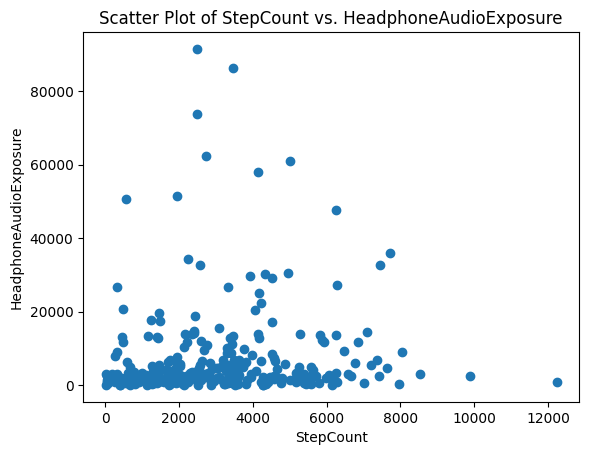

In [64]:
# Explore the data
print(df.describe())
print(df.isnull().sum())

# Visualize the relationship between variables
plt.scatter(df['StepCount'], df['HeadphoneAudioExposure'])
plt.xlabel('StepCount')
plt.ylabel('HeadphoneAudioExposure')
plt.title('Scatter Plot of StepCount vs. HeadphoneAudioExposure')
plt.show()


#5) Machine Learning

*   XGBoost Model
*   Random Forest Model



Mean Squared Error (XGBoost): 239256978.19934398


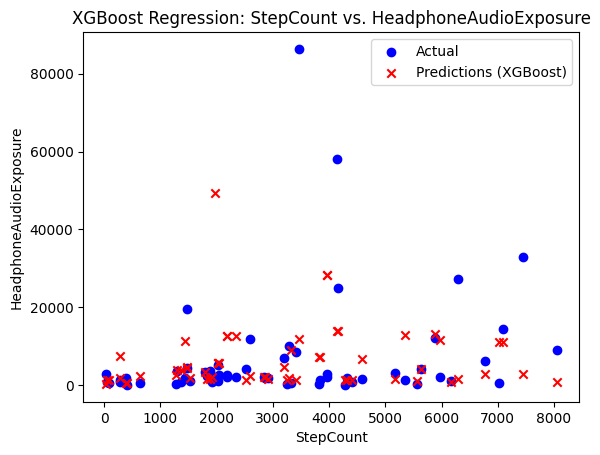

In [62]:
###             XGBOOST MODEL         ###
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error (XGBoost): {mse_xgb}')

# Visualize the relationship and the regression line
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred_xgb, color='red', marker='x', label='Predictions (XGBoost)')
plt.xlabel('StepCount')
plt.ylabel('HeadphoneAudioExposure')
plt.title('XGBoost Regression: StepCount vs. HeadphoneAudioExposure')
plt.legend()
plt.show()

Mean Squared Error (Random Forest): 196156506.03528118


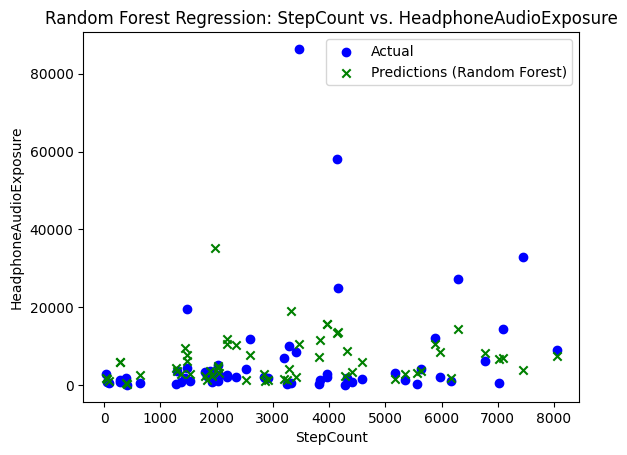

In [53]:
###            RANDOM FOREST MODEL          ######
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (Random Forest): {mse_rf}')

# Visualize the relationship and the regression line for Random Forest
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred_rf, color='green', marker='x', label='Predictions (Random Forest)')
plt.xlabel('StepCount')
plt.ylabel('HeadphoneAudioExposure')
plt.title('Random Forest Regression: StepCount vs. HeadphoneAudioExposure')
plt.legend()
plt.show()


#6) Comparison

*   Compare two models with visual data
*   Compare two models with numerical data



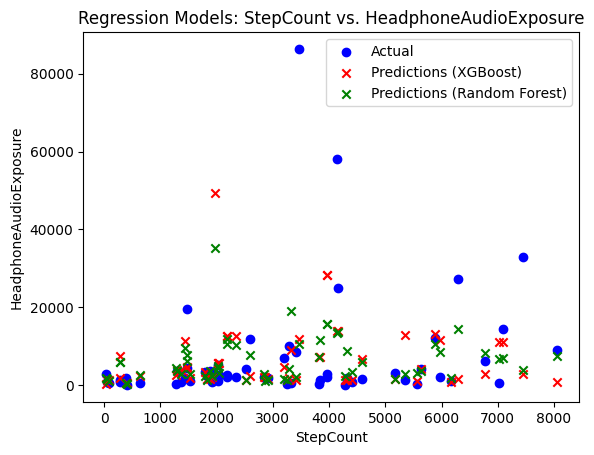

In [54]:
###       COMPARISON WITH VISUAL DATA        ###

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred_xgb, color='red', marker='x', label='Predictions (XGBoost)')
plt.scatter(X_test, y_pred_rf, color='green', marker='x', label='Predictions (Random Forest)')
plt.xlabel('StepCount')
plt.ylabel('HeadphoneAudioExposure')
plt.title('Regression Models: StepCount vs. HeadphoneAudioExposure')
plt.legend()
plt.show()


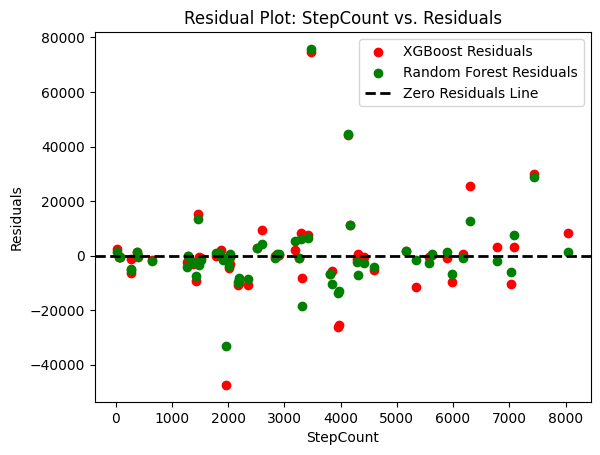

In [56]:
# Calculate residuals for both models
residuals_xgb = y_test - y_pred_xgb
residuals_rf = y_test - y_pred_rf

# Plot the residual plots
plt.scatter(X_test, residuals_xgb, color='red', label='XGBoost Residuals')
plt.scatter(X_test, residuals_rf, color='green', label='Random Forest Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Zero Residuals Line')
plt.xlabel('StepCount')
plt.ylabel('Residuals')
plt.title('Residual Plot: StepCount vs. Residuals')
plt.legend()
plt.show()


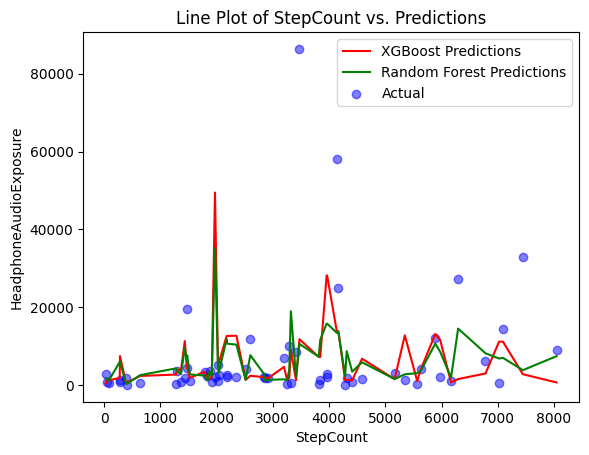

In [57]:
# Create a DataFrame with StepCount and Predictions
predictions_df = pd.DataFrame({'StepCount': X_test.flatten(), 'XGBoost_Predictions': y_pred_xgb, 'RandomForest_Predictions': y_pred_rf})

# Sort the DataFrame by StepCount for a smoother line plot
predictions_df = predictions_df.sort_values(by='StepCount')

# Plot the line plot
plt.plot(predictions_df['StepCount'], predictions_df['XGBoost_Predictions'], label='XGBoost Predictions', color='red')
plt.plot(predictions_df['StepCount'], predictions_df['RandomForest_Predictions'], label='Random Forest Predictions', color='green')
plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.5)
plt.xlabel('StepCount')
plt.ylabel('HeadphoneAudioExposure')
plt.title('Line Plot of StepCount vs. Predictions')
plt.legend()
plt.show()


In [63]:
###    COMPARISON WITH NUMERICAL DATA    ###

# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = np.mean(np.abs(y_test - y_pred_xgb))
r2_xgb = xgb_model.score(X_test, y_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = np.mean(np.abs(y_test - y_pred_rf))
r2_rf = rf_model.score(X_test, y_test)

print(f'MSE (Random Forest): {mse_rf}')
print(f'RMSE (Random Forest): {rmse_rf}')
print(f'MAE (Random Forest): {mae_rf}')
print(f'R-squared (Random Forest): {r2_rf}')

print(f'MSE (XGBoost): {mse_xgb}')
print(f'RMSE (XGBoost): {rmse_xgb}')
print(f'MAE (XGBoost): {mae_xgb}')
print(f'R-squared (XGBoost): {r2_xgb}')

MSE (Random Forest): 196156506.03528118
RMSE (Random Forest): 14005.588385900865
MAE (Random Forest): 7131.660850194445
R-squared (Random Forest): 0.011507804989883796
MSE (XGBoost): 239256978.19934398
RMSE (XGBoost): 15467.933869762437
MAE (XGBoost): 8052.368574804686
R-squared (XGBoost): -0.2056885613022641
